<a href="https://colab.research.google.com/github/behdad13/time-series-forecasting/blob/main/LSTM_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## importing necessary libraries 

In [ ]:
#installing necessary libraries
!pip install torch
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import necessary libraries
import os
import random
import time
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from numpy import array
from sklearn.preprocessing import MinMaxScaler
import optuna
from optuna.trial import TrialState
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.nn.functional as F
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
#set seed
seed_val = 67
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## importing pre-processed dataset

In [ ]:
#import the dataset
data = pd.read_csv('Data_Toronto.csv', low_memory=False)

#select the most relevent feature from the dataset
data = data[['Year', 'Month', 'Day', 'Hour', 'week_end','temperature', 'humidex', 'Ontario_Real_price', 'Electricity_Load']]

In [ ]:
#define the test and train set
seq = 5*24
horizon = 24
train = data.iloc[17520+8760+8786 - seq : 43824 + horizon]
test = data.iloc[43824 - seq : 43824+30*24 + horizon]

## train-val-test split

In [ ]:
#defining the training proportion
#seperating train and validation set
train_size = int(len(data)*0.80)      
valid_size = int(len(data)*0.20)
df_train, df_val = data[:train_size], data[train_size+1:]
df_train.shape, df_val.shape, test.shape

((38534, 9), (9633, 9), (864, 9))

In [ ]:
# scaling each features of the dataset
scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train),index = df_train.index, columns = df_train.columns)
df_val = pd.DataFrame(scaler.transform(df_val),index = df_val.index, columns = df_val.columns)
test = pd.DataFrame(scaler.transform(test),index = test.index, columns = test.columns)

## Make a time sequneces

In [ ]:
df_train = df_train.to_numpy()
df_val = df_val.to_numpy()
test = test.to_numpy()

In [ ]:
# split a multivariate sequence into samples
from numpy import array
def split_sequences(sequences, n_steps, for_hor):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-for_hor:
            break
        # gather input and output parts of the pattern
        # sequence_x ranges from 0 to seq_len and all columns except the last one.
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:end_ix+for_hor, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
n_timesteps = 24*5
for_hor = 24
X_train, y_train = split_sequences(df_train, n_timesteps, for_hor)
X_val, y_val = split_sequences(df_val, n_timesteps, for_hor)
X_test, y_test = split_sequences(test, n_timesteps, for_hor)

In [ ]:
print(X_test.shape, y_test.shape)

(721, 120, 9) (721, 24)


In [ ]:
n_timesteps + len(X_train) + for_hor-1 == len(df_train)

True

 ## Data Loader

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch

batch_size = 64


X_train_t = torch.Tensor(X_train)
y_train_t = torch.Tensor(y_train)
X_val_t = torch.Tensor(X_val)
y_val_t = torch.Tensor(y_val)
X_test_t = torch.Tensor(X_test)
y_test_t = torch.Tensor(y_test)

train = TensorDataset(X_train_t, y_train_t)
val = TensorDataset(X_val_t, y_val_t)
test_w1 = TensorDataset(X_test_t, y_test_t)


train_loader = DataLoader(train, batch_size=batch_size, shuffle = True, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle = False, drop_last=True)
test_loader_one_w1 = DataLoader(test_w1, batch_size=1, shuffle = False, drop_last=True)

In [ ]:
#check the size of the train set
X_train_t.shape, y_train_t.shape

(torch.Size([38391, 120, 9]), torch.Size([38391, 24]))

In [ ]:
#just for testing the size of the batch
next(iter(train_loader))[1].size(), next(iter(train_loader))[0].size()

(torch.Size([64, 24]), torch.Size([64, 120, 9]))

## deep learning model

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size1, num_layers, output_dim, seq_len=72):     #hidden_size2,
        super(LSTM, self).__init__()
        
        self.seq_len = seq_len
        self.lstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size1,
            num_layers=num_layers,
            batch_first=True)
        
        #another layer can be added to the simple LSTM model 
        #self.lstm2 = nn.LSTM(
        #    input_size=hidden_size1,
        #    hidden_size=hidden_size2,
        #    num_layers=num_layers,
        #    batch_first=True)
        
        self.output_dim=output_dim
        self.fc1 = nn.Linear(hidden_size1*seq_len, output_dim) 
        #another fully connected layer can be added
        #self.fc2 = nn.Linear(128, output_dim) 

    def forward(self, x):
        x, (h_n, c_n) = self.lstm1(x)
        #x, (h_n, c_n) = self.lstm2(x)              #for an etra layer
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        #x = self.fc2(x)
        return x

In [ ]:
#defining an objective function of the bayesian Optimization and which parameters need to be tuned
epochs = 250 
patience = 20
loss = nn.MSELoss()
min_val_loss_total=np.inf

def objective(trial):
    #define the infinity variable
    min_val_loss = np.inf
    
    
    # Generate the model.
    model = LSTM(input_size = 9, hidden_size1 = trial.suggest_int("hidden_dim1", 16, 128),
                num_layers=1,
                output_dim=24, 
                seq_len=5*24).cuda()
                #hidden_size2 = trial.suggest_int("hidden_dim2", 16, 128),    

    # Generate the optimizers.
    loss_fn = nn.MSELoss() 
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # Training of the model.
    counter = 0
    for i in range(epochs):
        mse_train = 0
        iteration_start = time.monotonic()
        for batch_x, batch_y in train_loader :
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            opt.zero_grad()
            y_pred = model(batch_x)
            y_pred = y_pred.squeeze(1)
            l = loss(y_pred, batch_y)
            l.backward()
            mse_train += l.item()*batch_x.shape[0]
            opt.step()
        with torch.no_grad():
            mse_val = 0
            preds = []
            true = []
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()
                output = model(batch_x)
                output = output.squeeze(1)
                preds.append(output.detach().cpu().numpy())
                true.append(batch_y.detach().cpu().numpy())
                mse_val += loss(output, batch_y).item()*batch_x.shape[0]
        preds = np.concatenate(preds)
        true = np.concatenate(true)

        if min_val_loss > mse_val:
            min_val_loss = mse_val
            counter = 0
        else: 
            counter += 1
        if counter == patience:
            break   

        global min_val_loss_total
        if min_val_loss_total > mse_val:
            min_val_loss_total = mse_val
            torch.save(model.state_dict(), "LSTM.pt")


        if i % 20 == 0:
            print("Iter: ", i, "train: ", (mse_train), "val: ", (mse_val))
        
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        trial.report(min_val_loss, i)
        
            # Save a trained model to a file.
        #with open("CNN.pickle".format(trial.number), "wb") as fout:
        #    pickle.dump(model, fout)
    return min_val_loss

In [ ]:
if __name__ == "__main__":
    #create the study
    study = optuna.create_study(direction="minimize", 
                                sampler=optuna.samplers.TPESampler(), 
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

    #calling the optimzation process
    study.optimize(objective, n_trials=40)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    #with open("CNN.pickle".format(study.best_trial.number), "rb") as fin:
    #    best_clf = pickle.load(fin)

[I 2022-12-22 15:11:11,832] A new study created in memory with name: no-name-92fe3ede-38a7-40a6-835d-42cf835e5411


Iter:  0 train:  239.9426202699542 val:  37.44992705062032
Iter:  20 train:  56.218227073550224 val:  25.56509831547737
Iter:  40 train:  47.58074855059385 val:  28.095694987103343


[I 2022-12-22 15:12:47,881] Trial 0 finished with value: 22.48655457329005 and parameters: {'hidden_dim1': 41, 'lr': 0.00048337760087052755}. Best is trial 0 with value: 22.48655457329005.


Iter:  0 train:  894.5741659402847 val:  116.17636825144291
Iter:  20 train:  94.29706286638975 val:  31.16351779550314
Iter:  40 train:  78.90854558348656 val:  27.254981255158782
Iter:  60 train:  72.15619220212102 val:  25.27108622342348
Iter:  80 train:  69.05476500093937 val:  24.175182519480586
Iter:  100 train:  66.43332022055984 val:  23.871278510428965
Iter:  120 train:  64.42376033216715 val:  24.430756306275725
Iter:  140 train:  62.547682266682386 val:  23.773893137462437
Iter:  160 train:  60.68098770081997 val:  23.90309201180935


[I 2022-12-22 15:18:48,457] Trial 1 finished with value: 23.165023263543844 and parameters: {'hidden_dim1': 92, 'lr': 1.04653531294636e-05}. Best is trial 0 with value: 22.48655457329005.


Iter:  0 train:  345.45183239877224 val:  49.023757223039865
Iter:  20 train:  69.52899711579084 val:  24.42654847446829
Iter:  40 train:  60.30722376704216 val:  23.8104193424806
Iter:  60 train:  55.72166895866394 val:  22.884984438307583
Iter:  80 train:  52.0694676078856 val:  23.763434141874313


[I 2022-12-22 15:21:59,558] Trial 2 finished with value: 22.471052068285644 and parameters: {'hidden_dim1': 33, 'lr': 0.00010538164332291793}. Best is trial 2 with value: 22.471052068285644.


Iter:  0 train:  548.8904331326485 val:  65.51846566051245
Iter:  20 train:  76.11689109355211 val:  26.742345516569912
Iter:  40 train:  65.84606410562992 val:  24.141516090370715
Iter:  60 train:  61.24881798401475 val:  24.085343223065138
Iter:  80 train:  57.032238222658634 val:  24.314188171178102


[I 2022-12-22 15:25:34,419] Trial 3 finished with value: 23.107825343497097 and parameters: {'hidden_dim1': 58, 'lr': 3.4366511253700246e-05}. Best is trial 2 with value: 22.471052068285644.


Iter:  0 train:  212.15071918070316 val:  38.2436783965677
Iter:  20 train:  55.51391125097871 val:  25.431686631403863
Iter:  40 train:  43.73146145418286 val:  86.86000650934875


[I 2022-12-22 15:28:02,805] Trial 4 finished with value: 21.274850596673787 and parameters: {'hidden_dim1': 115, 'lr': 0.00020008856664127558}. Best is trial 4 with value: 21.274850596673787.


Iter:  0 train:  519.7278234809637 val:  65.68948548287153


[I 2022-12-22 15:28:17,102] Trial 5 pruned. 


Iter:  0 train:  206.11850878596306 val:  34.32943699322641
Iter:  20 train:  54.5574315674603 val:  23.367604915052652
Iter:  40 train:  42.66602165997028 val:  27.300415128469467


[I 2022-12-22 15:30:36,217] Trial 6 finished with value: 21.866384332999587 and parameters: {'hidden_dim1': 116, 'lr': 0.0002596155244928141}. Best is trial 4 with value: 21.274850596673787.


Iter:  0 train:  524.3926165699959 val:  66.25312688201666


[I 2022-12-22 15:30:51,837] Trial 7 pruned. 


Iter:  0 train:  394.52595041692257 val:  54.471833381801844


[I 2022-12-22 15:31:12,171] Trial 8 pruned. 


Iter:  0 train:  231.4220371618867 val:  44.52148696407676
Iter:  20 train:  57.084053352475166 val:  23.674304590560496
Iter:  40 train:  46.91096004098654 val:  22.96644651144743


[I 2022-12-22 15:33:14,701] Trial 9 finished with value: 21.493288372643292 and parameters: {'hidden_dim1': 81, 'lr': 0.00020406572744819624}. Best is trial 4 with value: 21.274850596673787.


Iter:  0 train:  182.96170963346958 val:  32.438901061192155
Iter:  20 train:  50.017047081142664 val:  25.02687766775489
Iter:  40 train:  36.286203909665346 val:  35.077275870367885


[I 2022-12-22 15:35:11,235] Trial 10 finished with value: 21.103583961725235 and parameters: {'hidden_dim1': 105, 'lr': 0.0009522367011007912}. Best is trial 10 with value: 21.103583961725235.


Iter:  0 train:  181.50823252648115 val:  31.284719198942184
Iter:  20 train:  49.76646962016821 val:  24.998829778283834
Iter:  40 train:  37.95622569322586 val:  25.617313446477056


[I 2022-12-22 15:37:37,736] Trial 11 finished with value: 21.297629864886403 and parameters: {'hidden_dim1': 105, 'lr': 0.000842702559437248}. Best is trial 10 with value: 21.103583961725235.


Iter:  0 train:  168.1094961464405 val:  32.598734367638826
Iter:  20 train:  49.12630822509527 val:  23.070601634681225


[I 2022-12-22 15:38:54,269] Trial 12 pruned. 


Iter:  0 train:  291.5833585113287 val:  53.672290086746216


[I 2022-12-22 15:39:13,122] Trial 13 pruned. 


Iter:  0 train:  281.59347964823246 val:  41.18815046176314


[I 2022-12-22 15:39:29,444] Trial 14 pruned. 


Iter:  0 train:  177.17204597592354 val:  33.046279314905405
Iter:  20 train:  50.059330869466066 val:  21.938612231984735


[I 2022-12-22 15:40:49,706] Trial 15 pruned. 


Iter:  0 train:  243.20100116729736 val:  41.349610690027475


[I 2022-12-22 15:41:09,828] Trial 16 pruned. 


Iter:  0 train:  318.9446671307087 val:  47.383566070348024


[I 2022-12-22 15:41:25,014] Trial 17 pruned. 


Iter:  0 train:  736.5110452771187 val:  87.27058833837509


[I 2022-12-22 15:41:44,226] Trial 18 pruned. 


Iter:  0 train:  191.2303295135498 val:  34.78984377346933


[I 2022-12-22 15:42:03,603] Trial 19 pruned. 


Iter:  0 train:  175.02192490547895 val:  31.999895181506872
Iter:  20 train:  50.99435506388545 val:  22.22723906300962
Iter:  40 train:  46.8823160789907 val:  20.633975999429822


[I 2022-12-22 15:44:09,595] Trial 20 finished with value: 20.014133314602077 and parameters: {'hidden_dim1': 95, 'lr': 0.0007081411143731926}. Best is trial 20 with value: 20.014133314602077.


Iter:  0 train:  176.17675605416298 val:  30.751520736142993


[I 2022-12-22 15:44:37,106] Trial 21 pruned. 


Iter:  0 train:  168.98167019337416 val:  35.87965294346213


[I 2022-12-22 15:44:57,713] Trial 22 pruned. 


Iter:  0 train:  210.80204837024212 val:  35.734552942216396


[I 2022-12-22 15:45:14,428] Trial 23 pruned. 


Iter:  0 train:  191.8177765980363 val:  34.79369354620576


[I 2022-12-22 15:45:31,593] Trial 24 pruned. 


Iter:  0 train:  164.9241464957595 val:  35.17797742784023
Iter:  20 train:  49.760283567011356 val:  23.075947164557874


[I 2022-12-22 15:47:27,789] Trial 25 finished with value: 21.647702174261212 and parameters: {'hidden_dim1': 128, 'lr': 0.0007912503672229801}. Best is trial 20 with value: 20.014133314602077.


Iter:  0 train:  230.12755946815014 val:  37.563972564414144


[I 2022-12-22 15:47:49,198] Trial 26 pruned. 


Iter:  0 train:  364.9647722542286 val:  55.20725080743432


[I 2022-12-22 15:48:08,834] Trial 27 pruned. 


Iter:  0 train:  541.3189115524292 val:  64.9174973256886


[I 2022-12-22 15:48:32,664] Trial 28 pruned. 


Iter:  0 train:  188.39980449527502 val:  32.44849484972656
Iter:  20 train:  53.15708142891526 val:  22.4051627907902


[I 2022-12-22 15:49:32,695] Trial 29 pruned. 


Iter:  0 train:  204.50898174196482 val:  36.56197931803763


[I 2022-12-22 15:49:54,860] Trial 30 pruned. 


Iter:  0 train:  160.7160886079073 val:  30.92353630438447
Iter:  20 train:  49.31044767424464 val:  22.302706291899085


[I 2022-12-22 15:52:03,135] Trial 31 finished with value: 20.720950117334723 and parameters: {'hidden_dim1': 107, 'lr': 0.0009283593668935191}. Best is trial 20 with value: 20.014133314602077.


Iter:  0 train:  175.43125265836716 val:  34.414405446499586
Iter:  20 train:  50.806779973208904 val:  26.52748061530292


[I 2022-12-22 15:53:46,942] Trial 32 finished with value: 21.267117782495916 and parameters: {'hidden_dim1': 108, 'lr': 0.0005646465972151155}. Best is trial 20 with value: 20.014133314602077.


Iter:  0 train:  173.69048165529966 val:  31.062259439378977


[I 2022-12-22 15:54:12,728] Trial 33 pruned. 


Iter:  0 train:  163.72847057133913 val:  32.828265856951475


[I 2022-12-22 15:54:46,802] Trial 34 pruned. 


Iter:  0 train:  190.5228429660201 val:  32.79436604306102


[I 2022-12-22 15:55:01,633] Trial 35 pruned. 


Iter:  0 train:  164.87201572954655 val:  31.346357978880405


[I 2022-12-22 15:55:21,552] Trial 36 pruned. 


Iter:  0 train:  166.44452030956745 val:  30.7457081861794


[I 2022-12-22 15:55:52,102] Trial 37 pruned. 


Iter:  0 train:  180.46077041327953 val:  32.55940157547593


[I 2022-12-22 15:56:06,811] Trial 38 pruned. 


Iter:  0 train:  179.2681484594941 val:  33.19607210718095


[I 2022-12-22 15:56:51,444] Trial 39 pruned. 


Study statistics: 
  Number of finished trials:  40
  Number of pruned trials:  27
  Number of complete trials:  13
Best trial:
  Value:  20.014133314602077
  Params: 
    hidden_dim1: 95
    lr: 0.0007081411143731926


<ipython-input-85-bfdeb51369ab>:2: ExperimentalWarning:

plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.



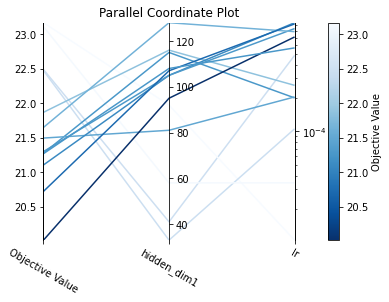

In [ ]:
#Visualizing sets of tunned yperparameters based on the BO
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["hidden_dim1", "lr" ])
optuna.visualization.plot_param_importances(study)

In [ ]:
#Download the PT file
from google.colab import files
files.download('LSTM_BO.pt')

In [ ]:
#Read the pk file
model = LSTM(input_size = 9,
             hidden_size1 = 95,
             num_layers=1,
             output_dim=24, 
             seq_len=5*24)

model.load_state_dict(torch.load("LSTM.pt"))

<All keys matched successfully>

In [ ]:
#call a desacaler function for the further analysis
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [ ]:
# the error calculation function
def calculate_metrics(values_descaled, prediction_descaled):
    result_metrics = {
                      'MAE' : mean_absolute_error(values_descaled, prediction_descaled),
                      'MSE' : mean_squared_error(values_descaled, prediction_descaled),
                      'R2'  : r2_score(values_descaled, prediction_descaled),
                      'MAPE': mean_absolute_percentage_error(values_descaled, prediction_descaled)
                      }
    print("Root Mean Squared Error :  ", result_metrics["MSE"]**0.5)
    print("R^2                :       ", result_metrics["R2"])
    print("Mean Absolute Error:       ", result_metrics["MAE"])
    print("MAPE               :       ", result_metrics["MAPE"])
    
    return result_metrics

Test set results

In [ ]:
# feeding the model with the test set.
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y in test_loader_one_w1:
        batch_x = batch_x
        batch_y = batch_y
        output = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().numpy())
        true.append(batch_y.detach().numpy())
preds = np.concatenate(preds)
true = np.concatenate(true)

Illustration of one-step, two-step, three-step, and 24-step ahead forecasting

error for next 1 hour prediction
Root Mean Squared Error :   71.32551968138618
R^2                :        0.9905633640597689
Mean Absolute Error:        51.05599285660107
MAPE               :        0.008877419190004584


error for next 2 hour prediction
Root Mean Squared Error :   94.6564239541885
R^2                :        0.9833122295187356
Mean Absolute Error:        72.05773908850554
MAPE               :        0.012248419832563688


error for next 3 hour prediction
Root Mean Squared Error :   109.56537782564344
R^2                :        0.9779232284135904
Mean Absolute Error:        83.99292398524184
MAPE               :        0.01424418755609878


error for next 24 hour prediction
Root Mean Squared Error :   246.6448308802556
R^2                :        0.8717845289763974
Mean Absolute Error:        199.68977819434812
MAPE               :        0.03402807460794641


1-step ahead forecast
2-step ahead forecast
3-step ahead forecast
24-step ahead forecast


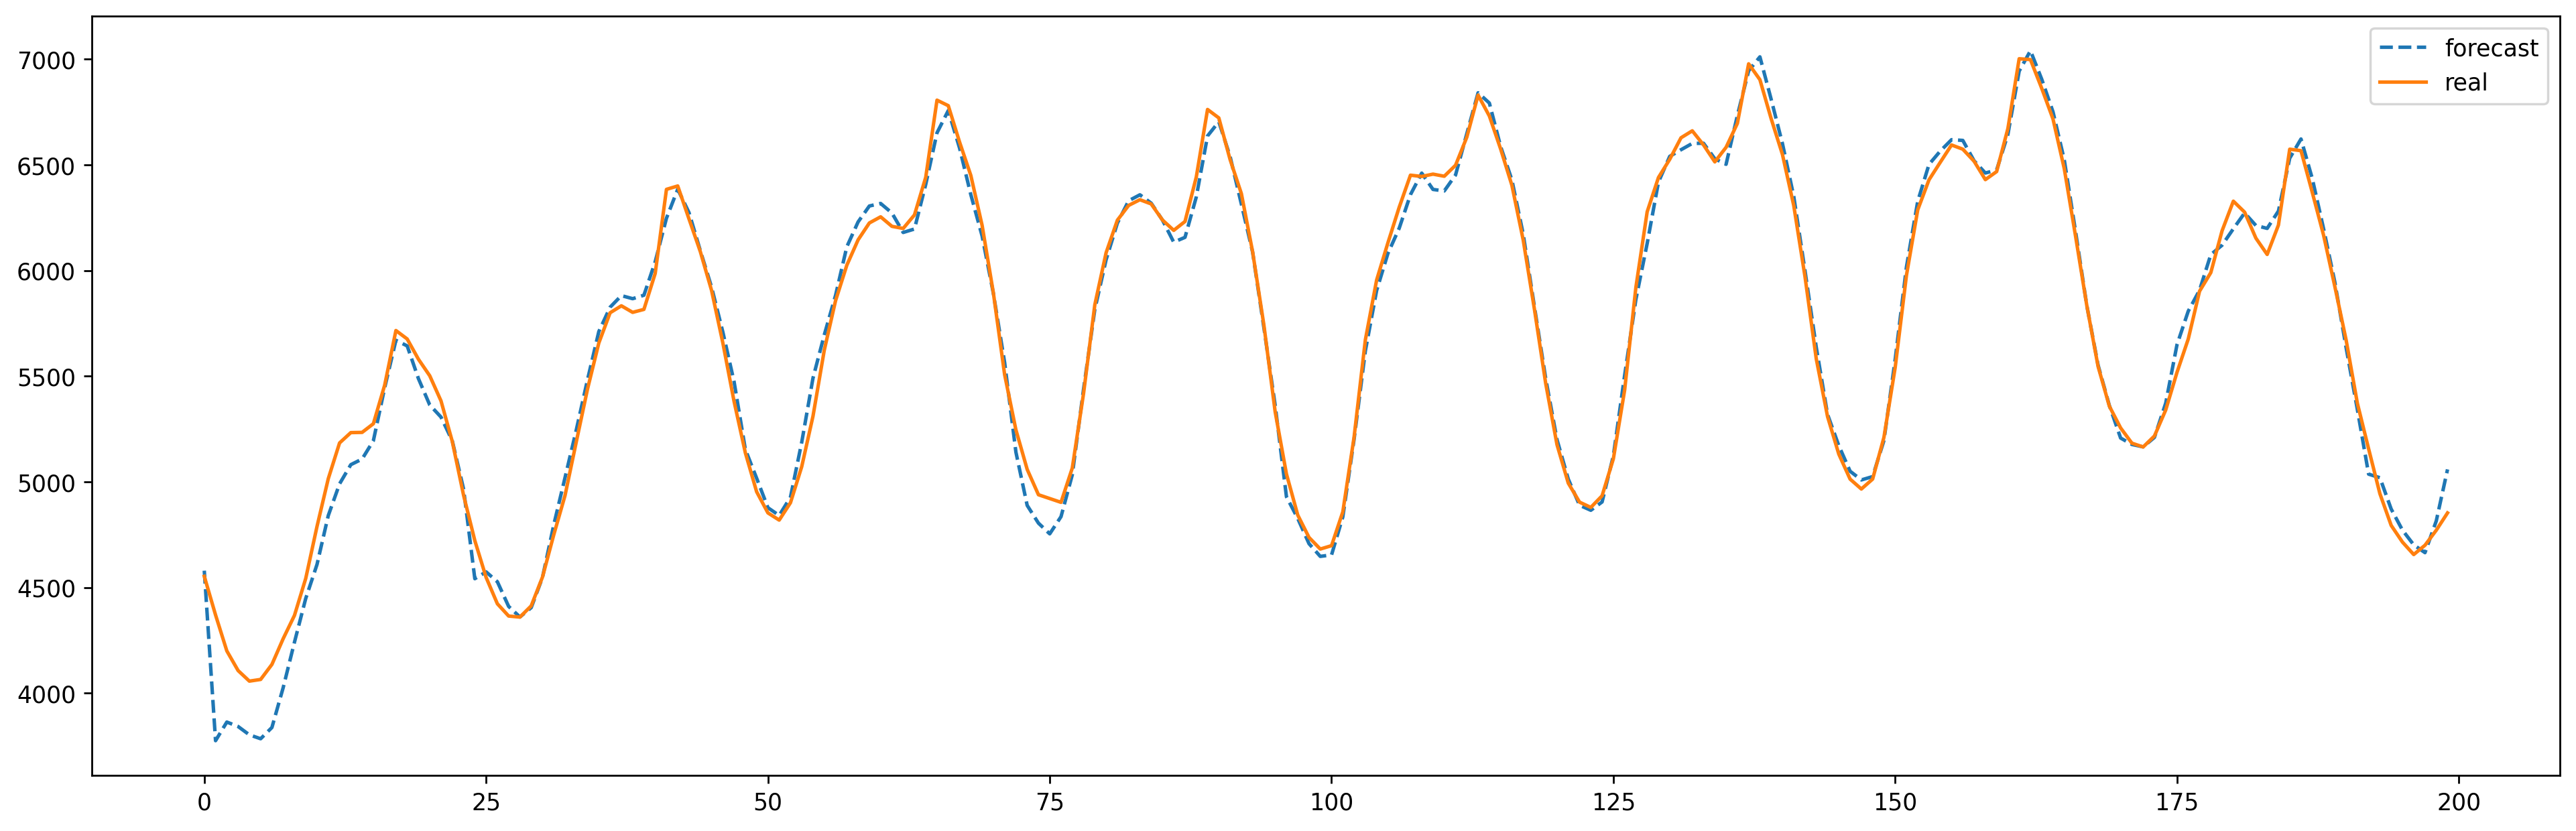

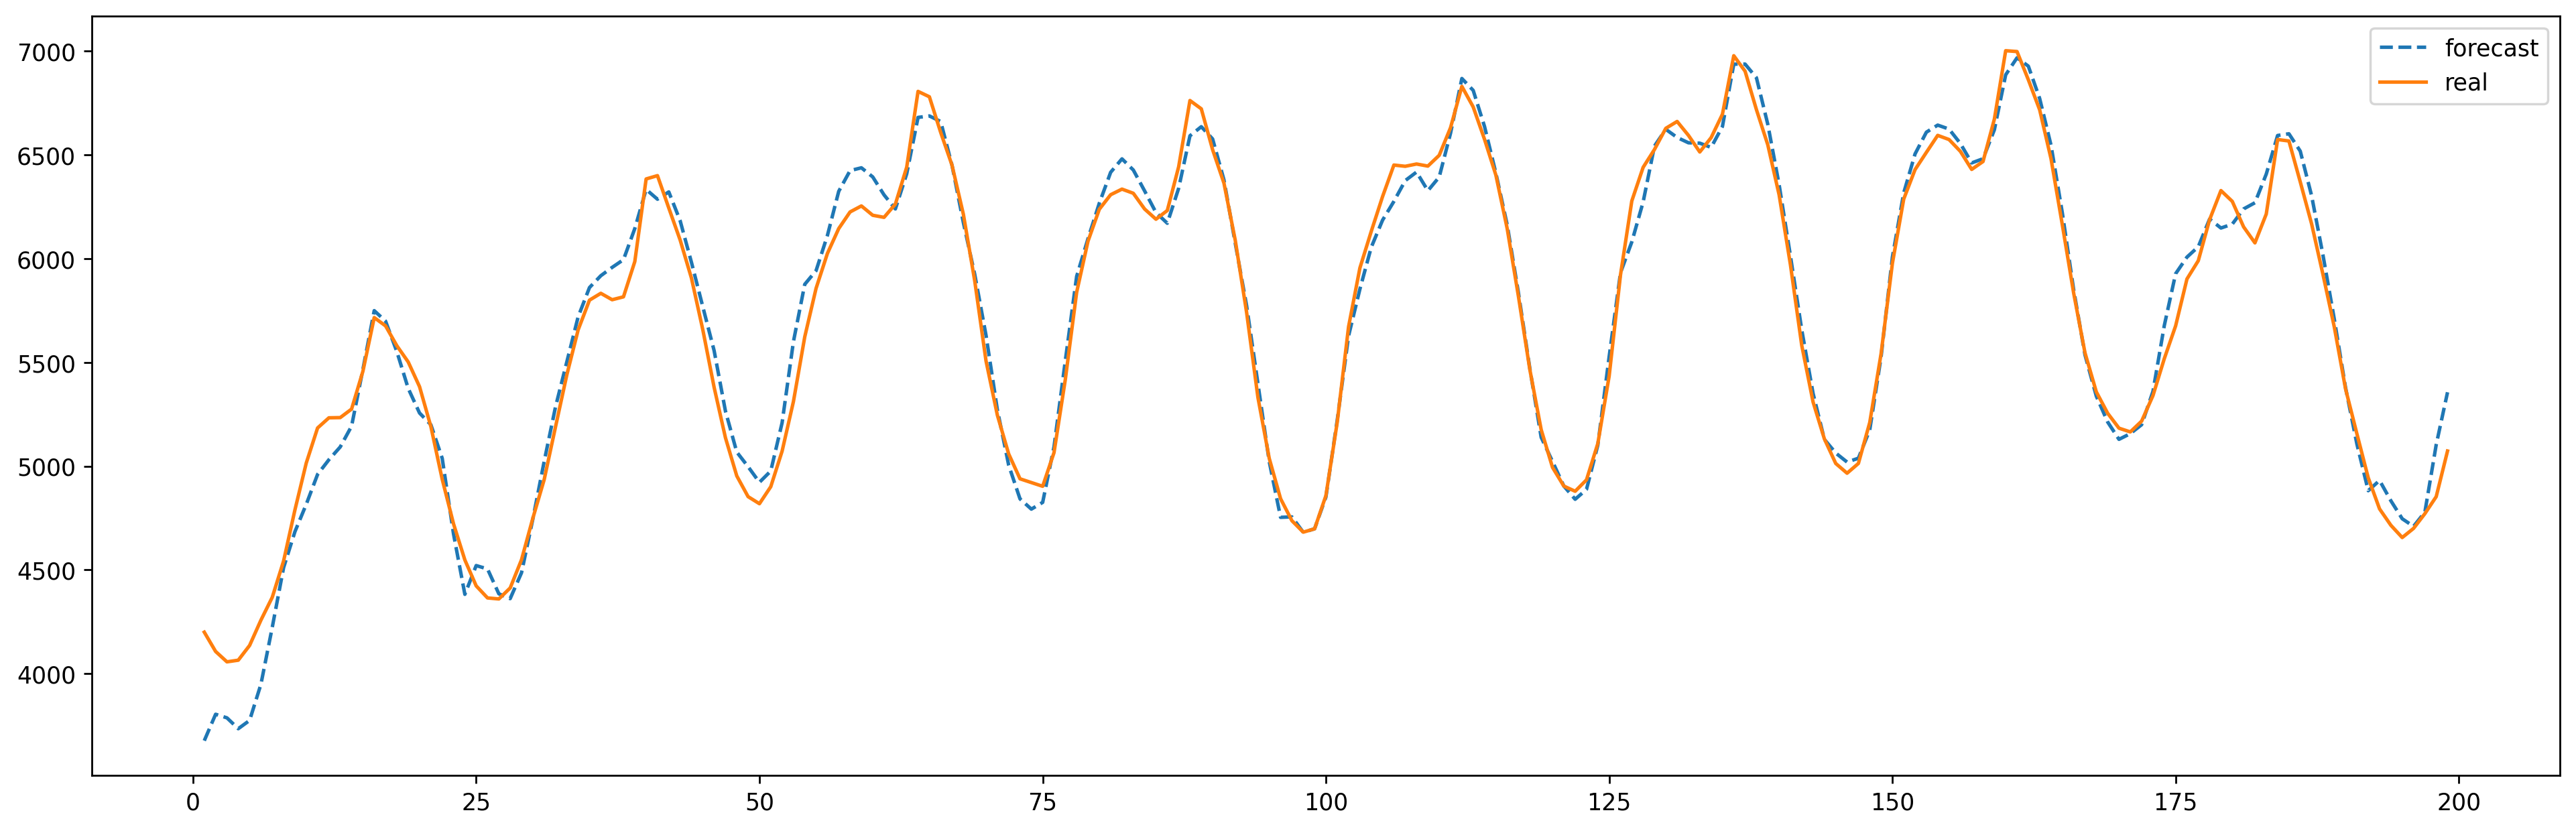

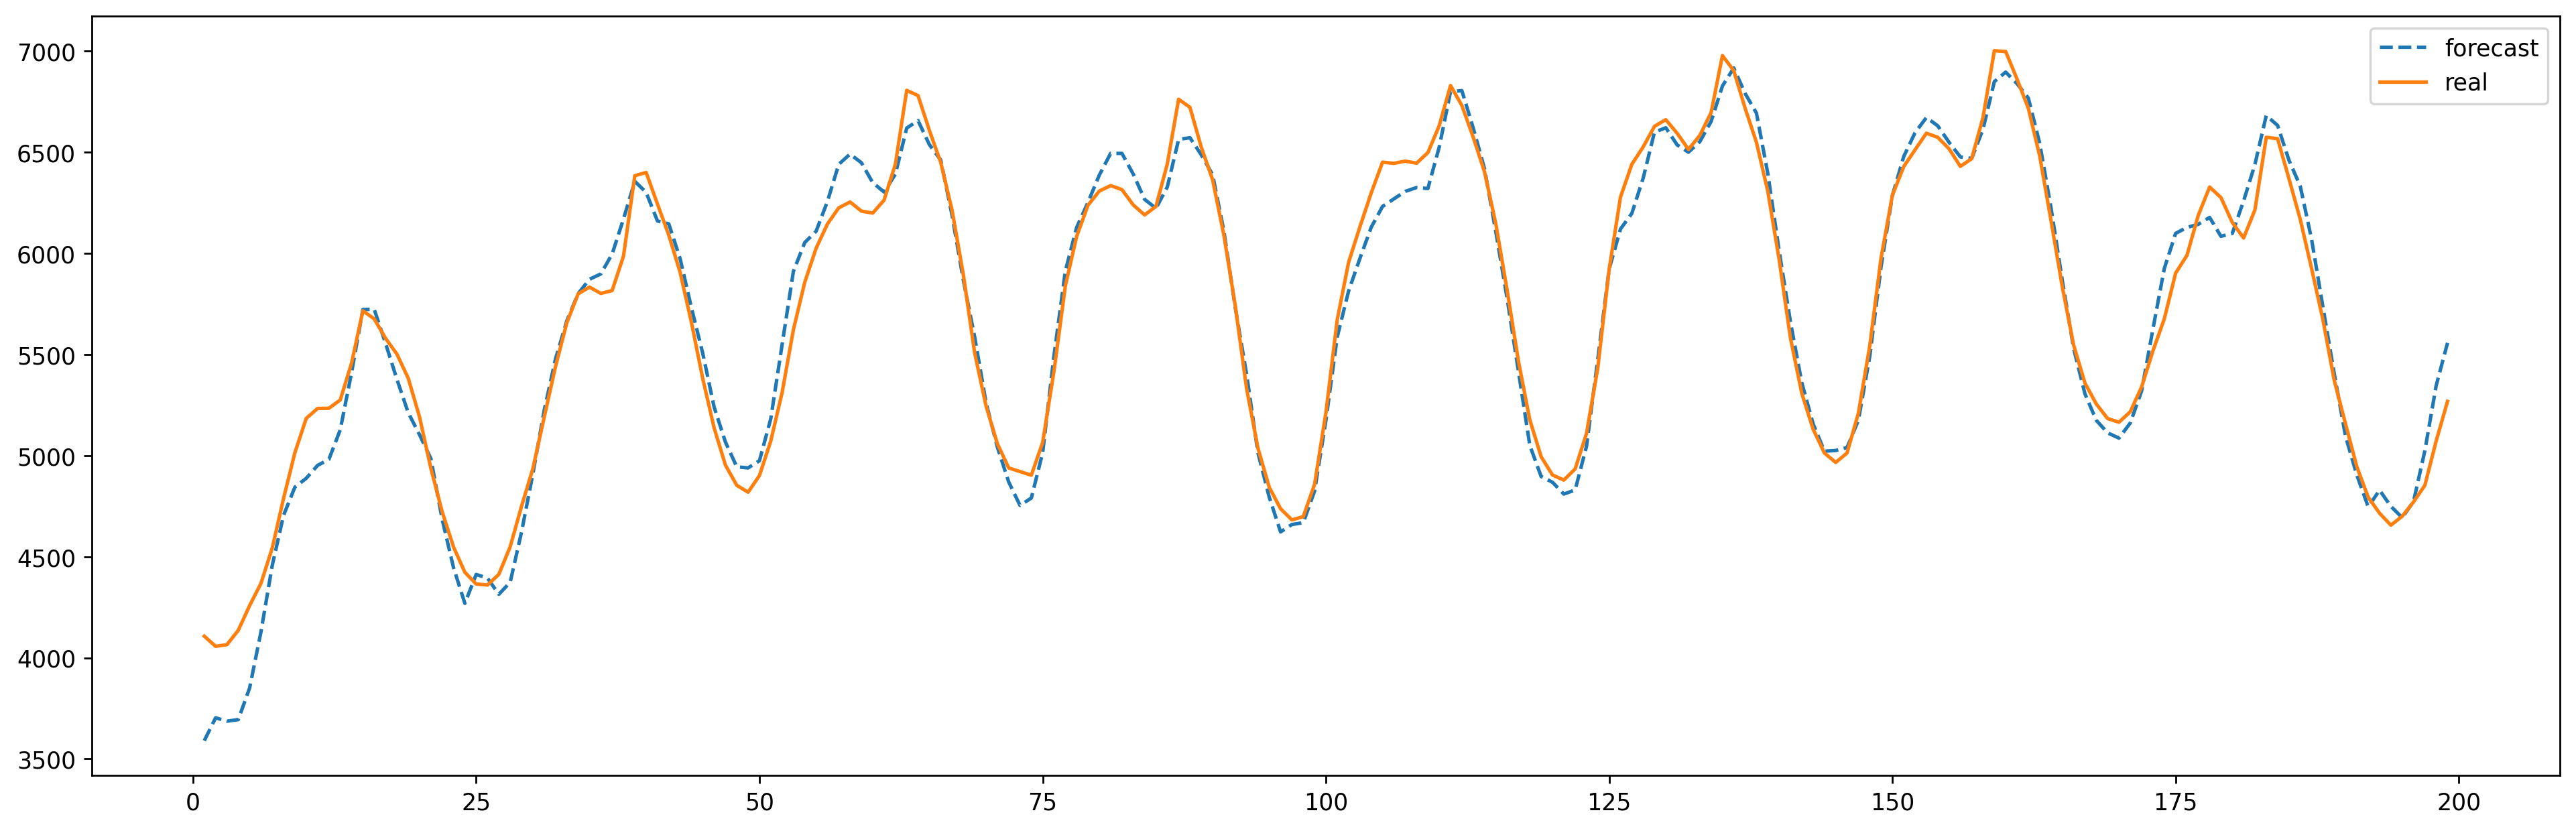

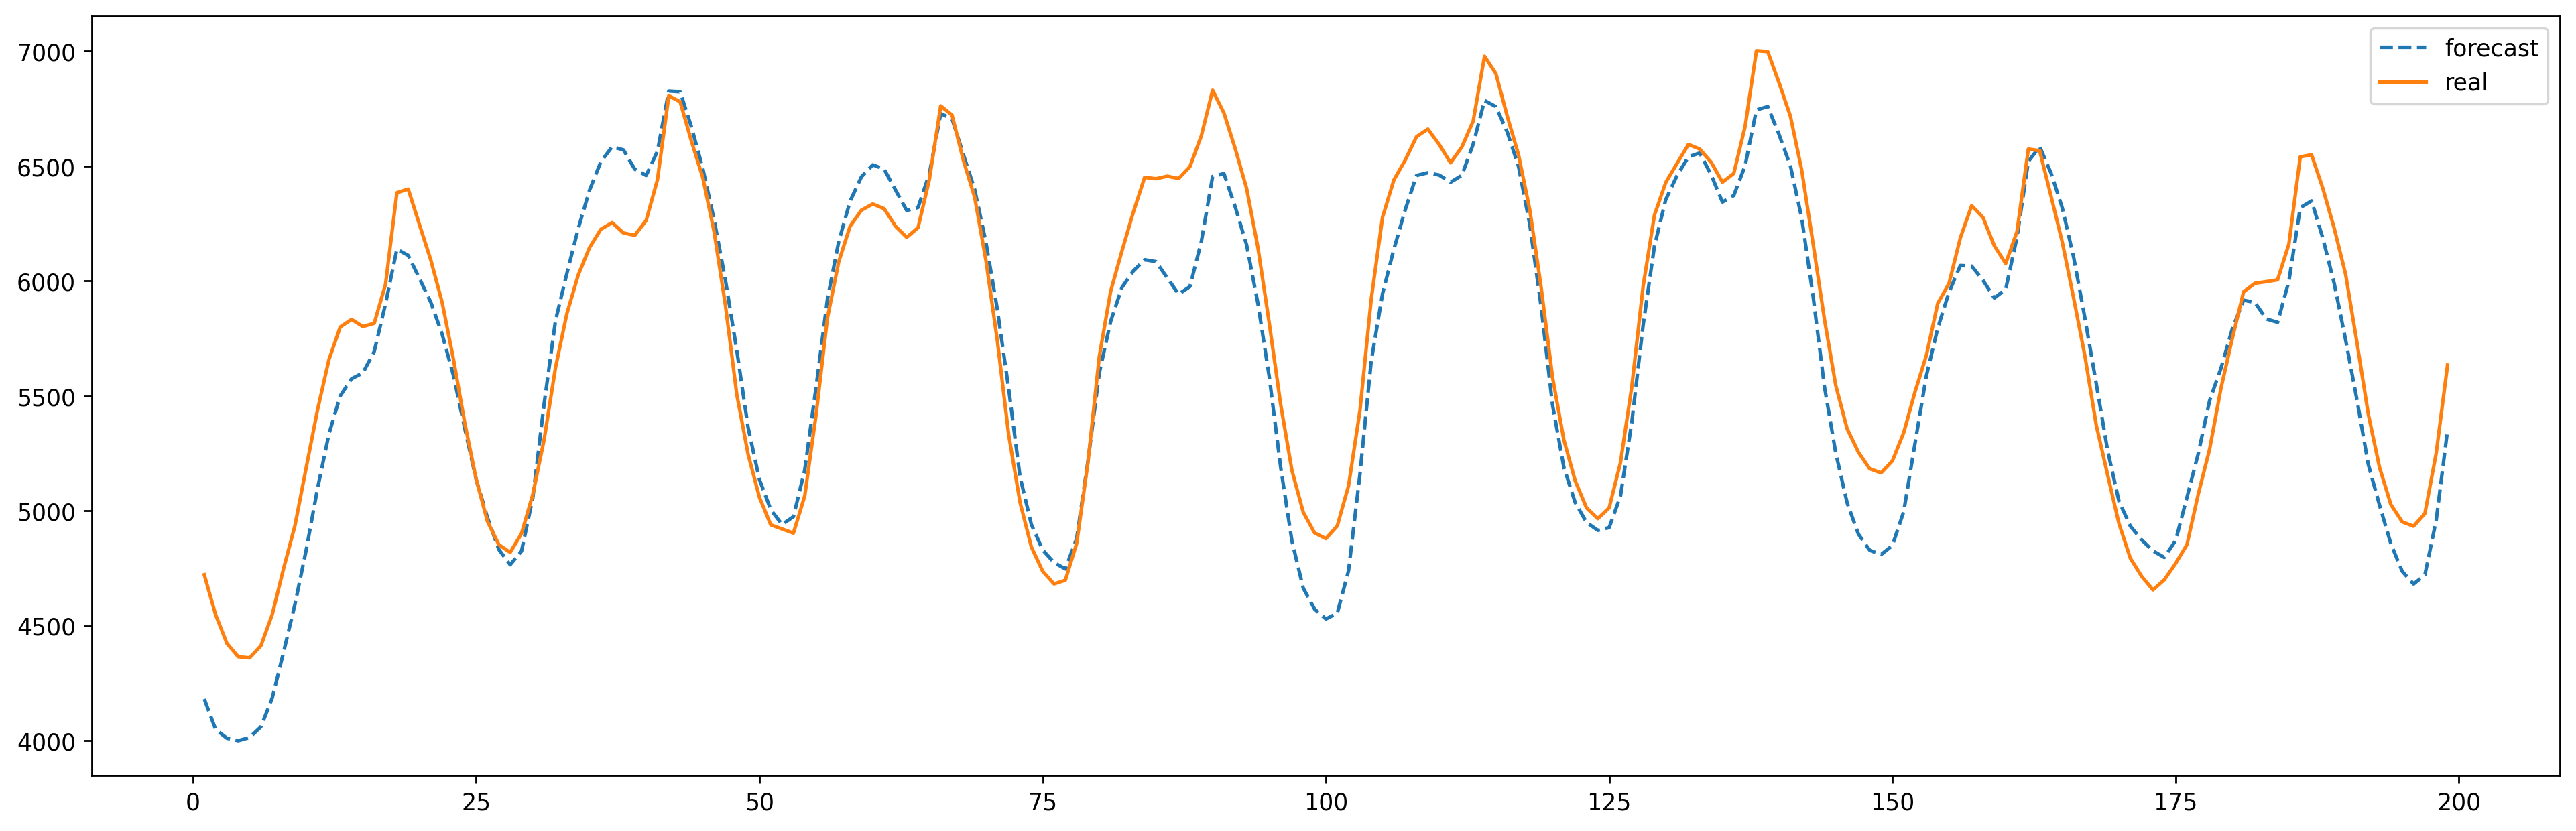

In [ ]:
# create an empty dataframe  
df = pd.DataFrame()
df['forcasted_demand_1h'] = 0
df['forcasted_demand_2h'] = 0
df['forcasted_demand_3h'] = 0
df['forcasted_demand_24h'] = 0
df['real_demand_1h'] = 0
df['real_demand_2h'] = 0
df['real_demand_3h'] = 0
df['real_demand_24h'] = 0

for i in range(len(preds)):
    prediction_descaled=[]
    values_descaled=[]
    prediction_descaled = descale(descaler, preds[[i]].reshape(-1))
    values_descaled = descale(descaler, true[[i]].reshape(-1))
    new_row = {'forcasted_demand_1h':prediction_descaled[0], 
           'forcasted_demand_2h':prediction_descaled[1], 
           'forcasted_demand_3h':prediction_descaled[2],
           'forcasted_demand_24h':prediction_descaled[23],
           'real_demand_1h' : values_descaled[0],
           'real_demand_2h' : values_descaled[1],
           'real_demand_3h' : values_descaled[2],
           'real_demand_24h' : values_descaled[23]}
    
    df = df.append(new_row, ignore_index=True)

print('error for next 1 hour prediction')
error_1h = calculate_metrics(df.forcasted_demand_1h,df.real_demand_1h )
print("\n")
print('error for next 2 hour prediction')
error_2h = calculate_metrics(df.forcasted_demand_2h,df.real_demand_2h )
print("\n")
print('error for next 3 hour prediction')
error_3h = calculate_metrics(df.forcasted_demand_3h,df.real_demand_3h )
print("\n")
print('error for next 24 hour prediction')
error_24h = calculate_metrics(df.forcasted_demand_24h,df.real_demand_24h )
print("\n")



print('1-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[0:200], df.forcasted_demand_1h[0:200], "--", label="forecast")
plt.plot(dates[0:200], df.real_demand_1h[0:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('2-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[1:200], df.forcasted_demand_2h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_2h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('3-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_3h))
plt.plot(dates[1:200], df.forcasted_demand_3h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_3h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();


print('24-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_24h))
plt.plot(dates[1:200], df.forcasted_demand_24h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_24h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

Visualizing the seires (the next 24-hour forecast)

In [ ]:
prediction_descaled=[]
values_descaled=[]
for i in range(len(preds)):
    prediction_descaled.append(descale(descaler, preds[[i]].reshape(-1)))
    values_descaled.append(descale(descaler, true[[i]].reshape(-1)))

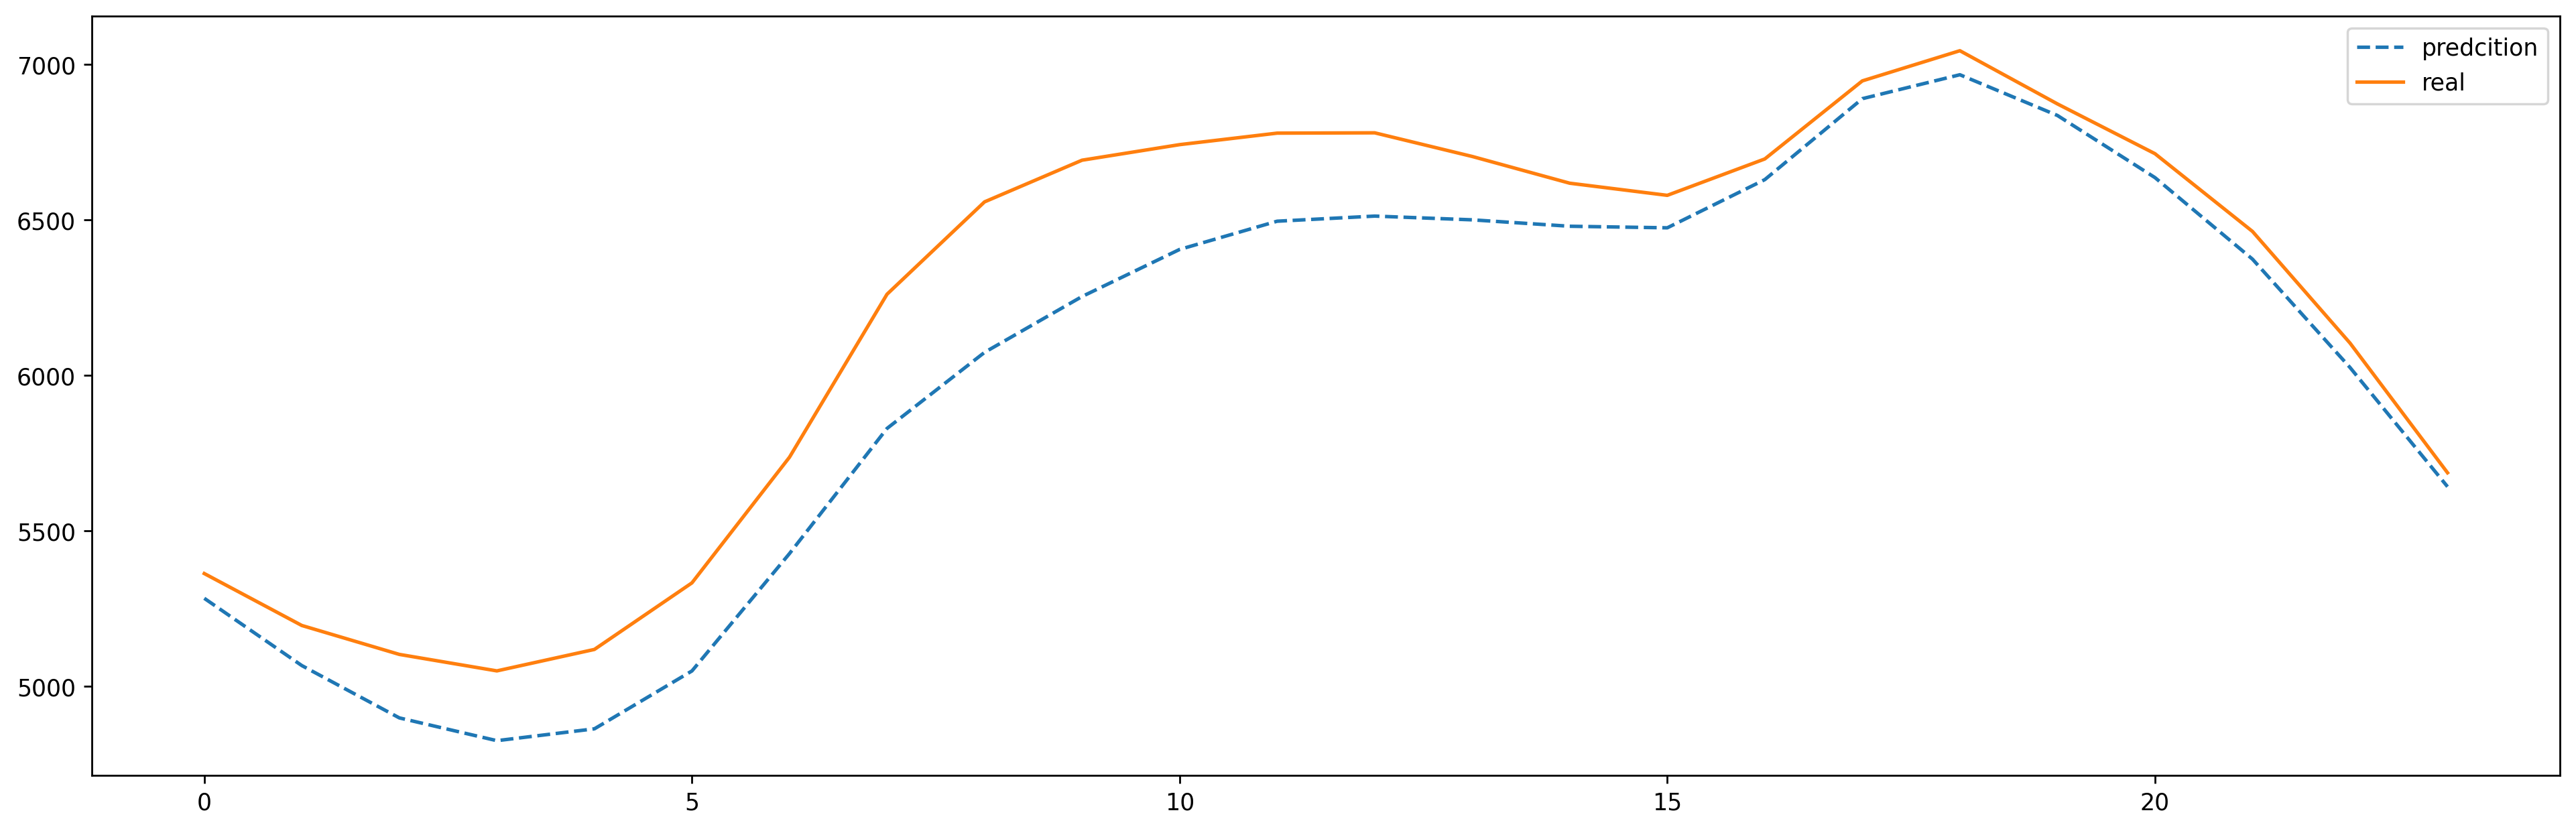

In [ ]:
figure(figsize=(19, 6), dpi=250)

j=30*24
dates = range(len(prediction_descaled[j]))
plt.plot(dates[0:24], prediction_descaled[j] , "--", label="predcition")
plt.plot(dates[0:24], values_descaled[j], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();
